# Protein conformational space exploration (CSE) using basins trajectories and a Generative Adversarial Network

**Packages required:**
    
* MDAnalysis
* MDAnalysisData
* matplotlib
* numpy
* sklearn
* tensorflow
* Bio
* nglview
* pytraj

In [1]:
import warnings
# avoid excessive warning messages to make the notebook nicer
warnings.filterwarnings('ignore')
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import os
import subprocess
import random
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import GRO, XTC
from MDAnalysis.analysis import dihedrals, rms, align
import MDAnalysisData as mda_data
from MDAnalysisData import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import savetxt,loadtxt
import sklearn as skl
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Layer,Dropout,Dense,Bidirectional
from tensorflow.keras.layers import GRU,LSTM,Embedding,MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization,Conv1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, model_from_json, load_model, clone_model
from tensorflow.python.client import device_lib
import nglview as nv
import Bio as bio
from Bio.SeqUtils import seq1, seq3
from itertools import chain, islice
import pytraj as pt
import h5py

import modeller as modl
from modeller import *
from modeller.automodel import *    # Load the AutoModel class
from modeller.scripts import complete_pdb
from modeller.optimizers import conjugate_gradients, molecular_dynamics, actions

print("mda version = {}".format(mda.__version__))
print("mda data version = {}".format(mda_data.__version__))
print("plt version = {}".format(matplotlib.__version__))
print("np version = {}".format(np.__version__))
print("skl version = {}".format(skl.__version__))
print("tf version = {}".format(tf.__version__))
print("bio version = {}".format(bio.__version__))
print("nglview version = {}".format(nv.__version__))
print("pytraj version = {}".format(pt.__version__))
print("modeller version = {}\n".format(modl.__version__))

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/dgatti/opt/anaconda3/envs/ana_md/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/Users/dgatti/opt/anaconda3/envs/ana_md/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


mda version = 2.0.0
mda data version = 0.8.1
plt version = 3.5.1
np version = 1.22.2
skl version = 1.0.2
tf version = 2.8.0
bio version = 1.78
nglview version = 3.0.3
pytraj version = 2.0.6
modeller version = 10.2



## Loading files

### Equilibrium adk trajectory

The file we work with here features adenylate kinase (AdK), a small protein of 214 residues. This is a long MD trajectory with 4187 frames covering over 1 $\mu s$. We will ignore solvent molecules. The variable 'protein' contains all the protein atoms in the MD.

In [3]:
# adk = datasets.fetch_adk_equilibrium()

# print(adk.DESCR)
# print(adk.topology)
# print(adk.trajectory)

In [4]:
# u_equil = mda.Universe(adk.topology, adk.trajectory)

# n_frames = len(u_equil.trajectory)
# print(f'There are {n_frames} frames in the trajectory')

# # Atom selection
# protein = u_equil.select_atoms('protein')
# print(f'There are {len(protein.residues)} protein residues in each frame')

### Multiple adk transition trajectories 

The file we work with here also feature adenylate kinase (AdK), but it is an ensemble of shorter trajectories, each containing a conformational transition. 

In [5]:
adk_trans = datasets.fetch_adk_transitions_DIMS()

print(adk_trans.DESCR)
print(adk_trans.topology) 

.. -*- coding: utf-8 -*-

.. _`adk-transitions-DIMS-dataset`:

AdK DIMS transitions ensemble dataset

The macromolecular conformational transition between the closed
conformation of apo-adenylate kinase from E. coli (EcAdK) to the open
conformation was sampled with two methods: (1) dynamic importance
sampling molecular dynamics (DIMS MD) [Perilla2009]_, and (2)
Framework Rigidity Optimized Dynamics Algorithm (FRODA)
[Farrell2010]_. Each ensemble of independently generated paths
contains 200 trajectories in the CHARMM DCD format.

This data set contains the **DIMS** ensemble.

DIMS AdK (implicit solvent) with dynamic importance sampling MD from
closed (1AKE) to open (4AKE). CHARMM 22 force field. Topology file:
adk4ake.psf


Notes
-----

Data set characteristics:

 :size: 757 MB
 :number of trajectories:  200	
 :number of frames:  varies
 :number of atoms: 3341
 :creator: Sean L. Seyler
 :URL:  `https://doi.org/10.6084/m9.figshare.7165306.v2 <https://doi.org/10.6084/m9.figshare.7165306.

In [6]:
# Here we examine the entire ensemble of trajectories. Later on we will use the 
# variable 'all_trj_nframes' to train recursively the VAE with all the trajectories
# in the ensemble
n_trj = len(adk_trans.trajectories)
all_trj_nframes = []

for i,trajectory in enumerate(adk_trans.trajectories):
    u = mda.Universe(adk_trans.topology, trajectory)
    single_trj_nframes = len(u.trajectory)
    all_trj_nframes.append(single_trj_nframes)

all_trj_nframes = np.array(all_trj_nframes)

print(f'Number of trajectories in the ensemble: {n_trj}')
print(f'Number of frames in each trajectory of the ensemble:')
print(*all_trj_nframes,'\n')

Number of trajectories in the ensemble: 200
Number of frames in each trajectory of the ensemble:
97 97 98 95 100 98 97 97 96 99 96 97 98 97 107 96 99 100 99 100 99 97 96 98 98 95 98 97 100 99 98 100 100 102 102 94 97 96 102 99 98 96 100 100 99 100 100 103 96 100 101 100 101 100 99 103 103 101 93 105 95 100 103 102 103 101 98 96 101 99 95 96 98 97 94 100 102 98 102 97 99 98 96 96 97 100 95 99 92 93 101 97 93 98 96 103 92 100 96 103 98 100 91 96 98 94 97 102 98 102 100 94 94 96 94 98 101 101 102 100 100 98 104 96 94 99 101 101 97 95 101 96 97 95 102 98 99 102 94 98 96 98 98 100 101 98 95 99 100 97 100 99 93 98 98 97 96 97 100 103 106 99 98 102 105 101 99 98 100 93 101 103 101 96 95 98 98 100 99 102 99 92 94 98 102 96 101 98 101 100 96 97 96 97 99 98 102 102 94 100 



### Validation, Test, and All sets

In [7]:
# Here we select the first two trajectories of the ensemble as the validation and test sets, respectively. 
# Later on we will loop through the other trajectories to train the NN.
u_val = mda.Universe(adk_trans.topology, adk_trans.trajectories[0])
u_test = mda.Universe(adk_trans.topology, adk_trans.trajectories[1])
u_all = mda.Universe(adk_trans.topology, adk_trans.trajectories)
print(f'Number of frames in the validation set: {len(u_val.trajectory)}')
print(f'Number of frames in the test set: {len(u_test.trajectory)}')
print(f'Number of frames in all sets: {len(u_all.trajectory)}')

Number of frames in the validation set: 97
Number of frames in the test set: 97
Number of frames in all sets: 19691


In [8]:
# Here we view the conformational transition of the validation trajectory 
view = nv.show_mdanalysis(u_val)
view.center()
view

NGLWidget(max_frame=96)

In [9]:
# Here we process the validation set
n_val_frames = len(u_val.trajectory)
print(f'There are {n_val_frames} frames in the validation trajectory')
val_protein = u_val.select_atoms('protein')
print(f'There are {len(val_protein.residues)} protein residues in each frame')

# Here we process the test set
n_test_frames = len(u_test.trajectory)
print(f'There are {n_test_frames} frames in the test trajectory')
test_protein = u_test.select_atoms('protein')
print(f'There are {len(test_protein.residues)} protein residues in each frame')

# Here we process all the trajectories of the ensemble  
n_all_frames = len(u_all.trajectory)
print(f'There are {n_all_frames} frames in the set of all trajectories')
all_protein = u_all.select_atoms('protein')
print(f'There are {len(all_protein.residues)} protein residues in each frame')


There are 97 frames in the validation trajectory
There are 214 protein residues in each frame
There are 97 frames in the test trajectory
There are 214 protein residues in each frame
There are 19691 frames in the set of all trajectories
There are 214 protein residues in each frame


## Ramachandran analysis

The `Ramachandran` class calculates the $\phi$ and $\psi$ angles of the selected residues over the course of a trajectory, saving it into `results.angles`. If residues are given that do not contain a $\phi$ and $\psi$ angle, they are omitted from the results. For example, the angles returned are from every residue in the protein *except* the first and last, for which a $\phi$ angle and a $\psi$ angle do not exist, respectively.

<img src="dihedral.png" style="width:400px;height:200px;">

The returned `results.angles` are in the shape (`n_frames`, `n_residues`, 2) where the last dimension holds the $\phi$ and $\psi$ angle.

`Ramachandran.plot()` plots the data from each time step onto a standard Ramachandran plot. Any keyword arguments (except `ax` and `ref`) are passed to `matplotlib.axes.Axes.scatter` to modify the plot. Setting `ref=True`, plots areas that show the allowed (dark blue) and marginally allowed (lighter blue) regions.

Ramachandran angles validation array shape: (97, 212, 2)
Ramachandran angles test array shape: (97, 212, 2)
Ramachandran angles all array shape: (19691, 212, 2)


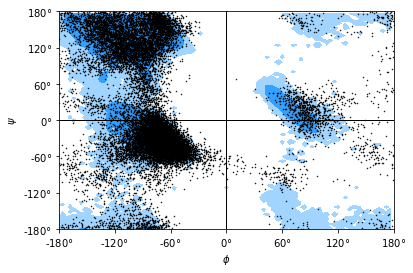

In [10]:
# Ramachandran angles for all the residues in val_protein. 
# To select a range of frames use .run(startframe,endframe+1)
val_rama = dihedrals.Ramachandran(val_protein).run()
val_rama.plot(color='black', marker='.', s=1, ref=True)
val_trj_phipsi = val_rama.results.angles
print(f'Ramachandran angles validation array shape: {val_trj_phipsi.shape}')

# Ramachandran angles for all the residues in test_protein.
test_rama = dihedrals.Ramachandran(test_protein).run()
test_trj_phipsi = test_rama.results.angles
print(f'Ramachandran angles test array shape: {test_trj_phipsi.shape}')

# Ramachandran angles for all the residues in all_protein.
all_rama = dihedrals.Ramachandran(all_protein).run()
all_trj_phipsi = all_rama.results.angles
print(f'Ramachandran angles all array shape: {all_trj_phipsi.shape}')

### Conversion of the trajectory into a lists of 4 symbols/frame.

Using simple selection of 4 attraction basins may ignore the actual distributions of angles during the dynamic. The function phipsi_to_basin offers the option to cluster the angles by k-means. We can shift the phi angles in order to obtain a better selection of basins.

In [11]:
def phipsi_to_basin(angles,phi_shift=-120.,cluster=False,n_clusters=4,plot=True):
    
    # Here, we reshape the sequence of frames so that the entire trajectory fits into 
    # a single 2D array for clustering
    shapes = angles.shape
    angles = np.reshape(angles,(shapes[0]*shapes[1],shapes[2]),order='C')

    # Shift in phi angles to obtain clean basins
    for value in angles:
        if value[1]<phi_shift:
            value[1] += 360.    

    init_centroids = np.array([[-100.,150],[-100.,-50.],[100.,-50.],[100.,150.]])
    kmeans = KMeans(n_clusters, 
                    init=init_centroids,
                    random_state=123,
                    algorithm='full').fit(angles)
    centroids = kmeans.cluster_centers_
    # score = kmeans.score(angles)
    
    if cluster:
        preds = kmeans.labels_
    else:
        preds = []
        for phipsi in angles:
            if phipsi[0]<=25. and phipsi[1]>70.:
                preds.append(0)
            elif phipsi[0]<=25. and phipsi[1]<=70.:
                preds.append(1)
            elif phipsi[0]>25. and phipsi[1]<=70.:
                preds.append(2)
            elif phipsi[0]>25. and phipsi[1]>70:
                preds.append(3)
        preds = np.array(preds) 
        
    if plot:
        x = [phipsi[0] for phipsi in angles]
        y = [phipsi[1] for phipsi in angles]

        # The scatter plot has markers colored by the basin cluster
        fig, (ax1) = plt.subplots(1,1)
        fig.set_figheight(5)
        fig.set_figwidth(7)
        fig.suptitle('Ramachandran plot with Basins predictions')
        scatterplot = ax1.scatter(x,y,s=1,c=preds)
        ax1.set_ylabel("psi angles")
        ax1.set_xlabel("phi angles")
        ax1.grid()

        # produce a legend with the unique colors from the scatter
        legend = ax1.legend(*scatterplot.legend_elements(),
                            loc="best", title="Classes")
        ax1.add_artist(legend)
        ax1.legend()
                
    basins = np.reshape(preds,(shapes[0],shapes[1]))
    angles = np.reshape(angles,(shapes[0],shapes[1],shapes[2]))            
        
    return angles,basins,centroids

### Basins 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


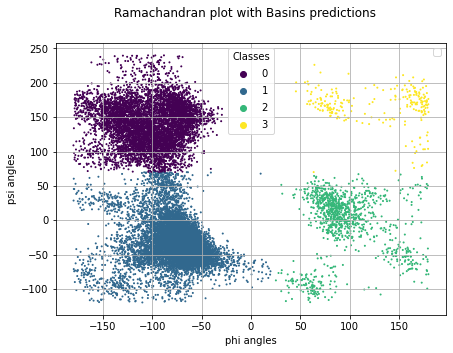

In [12]:
val_angles,val_basins,val_centroids = phipsi_to_basin(val_trj_phipsi,
                                                      phi_shift=-120.,
                                                      cluster=False,
                                                      n_clusters=4,
                                                      plot=True)


test_angles,test_basins,test_centroids = phipsi_to_basin(test_trj_phipsi,
                                                         phi_shift=-120.,
                                                         cluster=False,
                                                         n_clusters=4,
                                                         plot=False)


all_angles,all_basins,all_centroids = phipsi_to_basin(all_trj_phipsi,
                                                      phi_shift=-120.,
                                                      cluster=False,
                                                      n_clusters=4,
                                                      plot=False)

In [13]:
print(f'Validation centroids\n {val_centroids}')
print(f'Validation basin trj dimensions: {val_basins.shape}')
print(f'Validation basin trj: {val_basins}')

Validation centroids
 [[-102.97911129  137.48311941]
 [ -73.80445381  -35.30650969]
 [  94.83474066   -3.92823148]
 [ 127.8071452   166.7574127 ]]
Validation basin trj dimensions: (97, 212)
Validation basin trj: [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


Looks good: we can now use the predictions to convert the trj into an array of frames 
with each frame being an array of 4 symbols, one for each basin of attraction. First and last residues do not have phi-psi angles, so we only have 212 basins for the 214 residues of Adk.

### Datasets serving batches of inputs 

In [14]:
# Function to eliminate consecutive identical frames or 
# to skip frames in the basin trajectory
def reduce_basins(basins,ncycles,nskip):

    if ncycles == 0 and nskip > 1:
        trj = np.copy(basins)
        reduced_basins = np.array(trj[0::nskip,:])
    elif ncycles > 0 and nskip == 0:
        red_cycles = ncycles
        trj = np.copy(basins)

        for red_cycle in range(red_cycles):

            first_frame = np.array([trj[0]])
            # print(first_frame.shape,type(first_frame))

            count = 0
            reduced_trj = np.copy(first_frame)
            for i,frame in enumerate(trj):
                frame = np.array([frame])

                if i == 0:
                    previous_frame = first_frame

                if np.array_equal(previous_frame,frame):
                    previous_frame = frame
                    continue
                else:
                    count += 1
                    reduced_trj = np.append(reduced_trj,frame,axis=0)
                    previous_frame = frame

            # print(trj.shape)
            # print(count,reduced_trj.shape)
            trj = reduced_trj

        reduced_basins = trj
    
    return reduced_basins


# Function to pre-process basin trajectories
def preprocess_basins(basins,reduce = True,padding=2,reduce_cycles=2,skip_frames=0):
    if reduce:
        basins = reduce_basins(basins,reduce_cycles,skip_frames)
        
    n_frames = len(basins)   
    pad = np.zeros((padding,)) 
    basin_length = basins.shape[1] + 2*padding
    inputs = np.zeros((n_frames,basin_length))
    for i,basin_vec in enumerate(basins):
        basin_vec = (basin_vec + 1)/4
        basin_vec = np.concatenate((pad,basin_vec,pad),axis=0) 
        inputs[i] = basin_vec.astype("float32")
        
    return inputs


# Function to extend dimensions
def preprocessing_fn(x):
    x = tf.expand_dims(x,axis=-1)
    tf.cast(x, tf.float32)    
    return x


# Function to make a data.Dataset pipeline to serve batches of basin frames. 
# The number of parallel calls sets the number of cpu cores 
# used for serving data
def dataset_from_basin_trj(basins,reduce=True,padding=2,reduce_cycles=2,skip_frames=0,
                           batch_size='All',n_cpu=2,shuffle=True,
                           reshuffle=True,n_fetch=1,cache=False):
    
    inputs = preprocess_basins(basins,
                                reduce=reduce,
                                padding=padding,
                                reduce_cycles=reduce_cycles,
                                skip_frames=skip_frames)
    
    # Convert observed basin vectors to float 32 for compatibility 
    # with generated basin vectors
    inputs = inputs.astype('float32')
    
    # print(f'Inputs_type:{inputs.dtype}')
    
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    dataset = dataset.map(preprocessing_fn,num_parallel_calls=n_cpu)

    # Here we shuffle from a number of elements at least as large as 
    # the number of frames in the dataset and prefetch in memory n_fetch batches 
    # to speed up processing
    
    n_frames = len(inputs)

    if shuffle:
        dataset = dataset.shuffle(n_frames+1,reshuffle_each_iteration=reshuffle)

    if batch_size == 'All':
        batch_size = len(inputs)        

    dataset = dataset.batch(batch_size,
                            drop_remainder=True,
                            num_parallel_calls=n_cpu)
    
    dataset = dataset.prefetch(n_fetch).cache()
        
    return inputs,dataset

### Validation dataset

In [15]:
val_inputs,val_dataset = dataset_from_basin_trj(val_basins,
                                                reduce=True,
                                                reduce_cycles=2,
                                                skip_frames=0,
                                                padding=2,
                                                shuffle=True,
                                                batch_size=12,
                                                reshuffle=True,
                                                n_cpu=1,
                                                n_fetch=12)

print(f'Number of batches served: {len(val_dataset)}')

for inputs in val_dataset.take(1):
    print(f"Batch shape: {inputs.shape}")

# for i,element in enumerate(val_dataset.as_numpy_iterator()):
#     if i >= 7:
#         break
#     print(f'Element {i}:\n{element.shape}')
#     print(f'Element {i}:\n{element.dtype}')

2022-06-01 15:57:35.187873: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of batches served: 7
Batch shape: (12, 216, 1)


2022-06-01 15:57:35.408106: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


### Test dataset
Only generate this dataset as an alternative to the validation set for training.

In [16]:
# test_inputs,test_dataset = dataset_from_basin_trj(test_basins,
#                                                   reduce=True,
#                                                   reduce_cycles=2,
#                                                   skip_frames=0,
#                                                   padding=2,
#                                                   shuffle=True,
#                                                   batch_size=12,
#                                                   reshuffle=True,
#                                                   n_cpu=1,
#                                                   n_fetch=12)

# print(f'Number of batches served: {len(test_dataset)}')

# for inputs in test_dataset.take(1):
#     print(f"Batch shape: {inputs.shape}")

### All dataset
Only generate this dataset if using all trajectories at ones, rather than one at a time.

In [17]:
all_inputs,all_dataset = dataset_from_basin_trj(all_basins,
                                                reduce=True,
                                                reduce_cycles=2,
                                                skip_frames=0,
                                                padding=2,
                                                shuffle=True,
                                                batch_size=128,
                                                reshuffle=True,
                                                n_cpu=1,
                                                n_fetch=128)

print(f'Number of batches served: {len(all_dataset)}')

for inputs in all_dataset.take(1):
    print(f"Batch shape: {inputs.shape}")

Number of batches served: 140
Batch shape: (128, 216, 1)


2022-06-01 16:04:11.249655: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


#### DEVICES

In [18]:
physical_devices_GPU = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices_GPU))

physical_devices_CPU = tf.config.list_physical_devices('CPU') 
print("Num CPUs:", len(physical_devices_CPU)) 

local_device_protos = device_lib.list_local_devices()
print(local_device_protos)


Num GPUs: 0
Num CPUs: 1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12800795822262215248
xla_global_id: -1
]


### GAN

A Generative adversarial network (GAN) is an alternative to a Variational Auto Encoder (VAE) for learning latent spaces. Schematically, our GAN works like this:

A generator network maps vectors of shape (latent_dimensions = 128,) to basin vectors (216, 1).

A discriminator network maps basins vectors of shape (216,1) to a binary score estimating the probability that the vector is real.

A gan network chains the generator and the discriminator together: gan(x) = discriminator(generator(x)). Thus, this gan network maps latent space vectors to the discriminator’s assessment of the realism of these latent vectors as decoded by the generator.

We train the discriminator using examples of real and fake basins vectors along with real and fake” labels.

To train the generator, we use the gradients of the generator’s weights with respect to the loss of the gan model. This means that at every step, we move the weights of the generator in a direction that makes the discriminator more likely to classify as “real” the basins vectors decoded by the generator.


### The Discriminator
First, we develop a discriminator model that takes as input a candidate basins vector (real or synthetic) and classifies it into one of two classes: “generated basins vector” or “real basins vector that comes from the training set.” 

In [19]:
from tensorflow.keras import layers

# Clear all models
keras.backend.clear_session()

if 'discriminator' in globals():
    del discriminator
if 'generator' in globals():
    del generator
if 'gan' in globals():    
    del gan

dataset_shapes = val_dataset.element_spec.shape.as_list()
print(dataset_shapes)

discriminator = keras.Sequential(
    [
        keras.Input(shape=(dataset_shapes[1:])),
        layers.Conv1D(16, kernel_size=5, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv1D(32, kernel_size=5, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Conv1D(64, kernel_size=5, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Conv1D(128, kernel_size=5, strides=3, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1),
        # layers.Activation("sigmoid")
    ],
    name="discriminator",
)


discriminator.summary()

[12, 216, 1]
Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 108, 16)           96        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 108, 16)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 54, 32)            2592      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 54, 32)            0         
                                                                 
 dropout (Dropout)           (None, 54, 32)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 27, 64)            10304     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 27, 

### The Generator
Next, we develop a generator model that turns a vector from the latent space (during training this space will be sampled at random) into a candidate basins vector. We use sigmoid activation in the final Conv1D layer.

In [20]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(9 * 128),
        layers.Reshape((9, 128)),
        
        layers.Conv1DTranspose(128,kernel_size=5,strides=3,padding="same",use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),            
        layers.Conv1DTranspose(64,kernel_size=5,strides=2,padding="same",use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv1DTranspose(32,kernel_size=5,strides=2,padding="same",use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv1DTranspose(32,kernel_size=5,strides=2,padding="same",use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv1D(1, kernel_size=5, padding="same",use_bias=False),
        layers.BatchNormalization(),
        layers.Activation("sigmoid")
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 1152)              148608    
                                                                 
 reshape (Reshape)           (None, 9, 128)            0         
                                                                 
 conv1d_transpose (Conv1DTra  (None, 27, 128)          81920     
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 27, 128)          512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 27, 128)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 54, 64)           40

### The Adversarial Network (WGAN_GP)

Wasserstein GAN (WGAN) with Gradient Penalty (GP) [author: A.K. Nain, contribution to KERAS]

The original Wasserstein GAN leverages the Wasserstein distance to produce a value function that has better theoretical properties than the value function used in the original GAN paper. WGAN requires that the discriminator (aka the critic) lie within the space of 1-Lipschitz functions. The authors proposed the idea of weight clipping to achieve this constraint. Though weight clipping works, it can be a problematic way to enforce 1-Lipschitz constraint and can cause undesirable behavior, e.g. a very deep WGAN discriminator (critic) often fails to converge.

The WGAN-GP method proposes an alternative to weight clipping to ensure smooth training. Instead of clipping the weights, the authors proposed a "gradient penalty" by adding a loss term that keeps the L2 norm of the discriminator gradients close to 1.

**The WGAN model with custom `train_step()`**

After defining generator and discriminator, we implement the WGAN-GP model overriding the train_step for training. The code is modified from the original Keras example by A.K. Nain to work with basins vectors rather than images. 

In [21]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        # alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        # Mimmo
        alpha = tf.random.normal([batch_size, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        # norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        # Mimmo
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}

#### A callback that samples generated basins during training

In [22]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_basins=3, latent_dim=128):
        self.num_basins = num_basins
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_basins, 
                                                        self.latent_dim))
        generated_basins = self.model.generator(random_latent_vectors)
        generated_basins *= 4
        generated_basins = np.rint(generated_basins).astype('int32')
        generated_basins -= 1
               
        with open("Generated_basins_epoch_"+str(epoch)+".txt", "w") as text_file:        
            for i in range(self.num_basins):
                print(f'\nGenerated_basin_{i}:',file=text_file)
                print(*np.squeeze(generated_basins[i][2:-2]),file=text_file)
                

#### WGAN compilation

In [23]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5, beta_2=0.9 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_basins=3, latent_dim=latent_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim,
    discriminator_extra_steps=3,
)


**Saving the Discriminator and Generator Architectures**

In [24]:
# Saving of the untrained architecture
wgan.discriminator.save('discriminator_model.tf',
        overwrite=True,include_optimizer=False,save_format='tf',
                 signatures=None,options=None)
wgan.generator.save('generator_model.tf',
        overwrite=True,include_optimizer=False,save_format='tf',
                 signatures=None,options=None)

wgan.discriminator.save('discriminator_model.h5',
        overwrite=True,include_optimizer=False,save_format='h5',
                 signatures=None,options=None)
wgan.generator.save('generator_model.h5',
        overwrite=True,include_optimizer=False,save_format='h5',
                 signatures=None,options=None)

# Weight only saving
wgan.discriminator.save_weights('discriminator_model_weights.h5', overwrite=True, 
                         save_format='h5', options=None)
wgan.generator.save_weights('generator_model_weights.h5', overwrite=True, 
                         save_format='h5', options=None)

2022-06-01 16:04:13.249312: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: discriminator_model.tf/assets
INFO:tensorflow:Assets written to: generator_model.tf/assets


### Training with all the trajectories at once.


In [25]:
epochs = 60

# Clear all models
keras.backend.clear_session()
if 'discriminator' in globals():
    del discriminator
if 'generator' in globals():
    del generator
if 'all_gan' in globals():    
    del all_gan

# load discriminator and generator 
discriminator = keras.models.load_model("discriminator_model.tf")
generator = keras.models.load_model("generator_model.tf")

# Instantiate the WGAN model.
all_gan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
all_gan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)


all_history_gan = all_gan.fit(all_dataset,
                          epochs=epochs,
                          callbacks=[GANMonitor(num_basins=10,
                                                latent_dim=latent_dim)])            

all_d_loss = all_history_gan.history["d_loss"]
all_g_loss = all_history_gan.history["g_loss"]


Epoch 1/60
140/140 [==============================] - 102s 673ms/step - d_loss: -0.0570 - g_loss: 1.6201
Epoch 2/60
140/140 [==============================] - 77s 550ms/step - d_loss: -1.1947 - g_loss: 4.7618
Epoch 3/60
140/140 [==============================] - 72s 516ms/step - d_loss: -0.7889 - g_loss: 4.4072
Epoch 4/60
140/140 [==============================] - 70s 502ms/step - d_loss: -0.5504 - g_loss: 3.9473
Epoch 5/60
140/140 [==============================] - 74s 528ms/step - d_loss: -0.4251 - g_loss: 4.1367
Epoch 6/60
140/140 [==============================] - 68s 487ms/step - d_loss: -0.3247 - g_loss: 4.0392
Epoch 7/60
140/140 [==============================] - 69s 492ms/step - d_loss: -0.2299 - g_loss: 4.1559
Epoch 8/60
140/140 [==============================] - 69s 489ms/step - d_loss: -0.1510 - g_loss: 4.0657
Epoch 9/60
140/140 [==============================] - 69s 491ms/step - d_loss: -0.0815 - g_loss: 4.0000
Epoch 10/60
140/140 [==============================] - 77s 547m

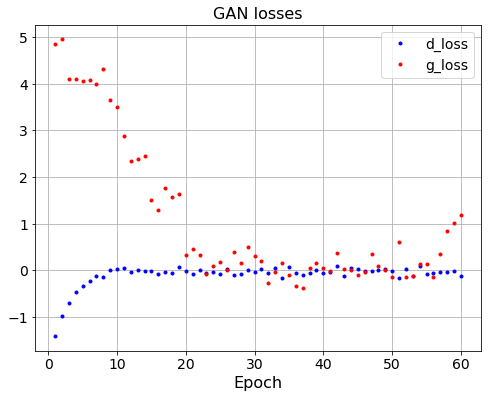

In [43]:
epochs = range(1, len(all_d_loss)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, all_d_loss, "b.", markersize=6, label="d_loss")
plt.plot(epochs, all_g_loss, "r.", markersize=6, label="g_loss")
plt.title("GAN losses",fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=14)
plt.show()
# plt.legend()
# plt.show()

In [27]:
# Saving the trained gan
all_gan.discriminator.save('all_discriminator.tf',
        overwrite=True,include_optimizer=False,save_format='tf',
                 signatures=None,options=None)
all_gan.generator.save('all_generator.tf',
        overwrite=True,include_optimizer=False,save_format='tf',
                 signatures=None,options=None)

all_gan.discriminator.save('all_discriminator.h5',
        overwrite=True,include_optimizer=False,save_format='h5',
                 signatures=None,options=None)
all_gan.generator.save('all_generator.h5',
        overwrite=True,include_optimizer=False,save_format='h5',
                 signatures=None,options=None)

# Weight only saving
all_gan.discriminator.save_weights('all_discriminator_weights.h5', overwrite=True, 
                         save_format='h5', options=None)
all_gan.generator.save_weights('all_generator_weights.h5', overwrite=True, 
                         save_format='h5', options=None)

INFO:tensorflow:Assets written to: all_discriminator.tf/assets
INFO:tensorflow:Assets written to: all_generator.tf/assets


### Modeller environment: reference structure

In [28]:
# using MDAnalysis write out without hydrogens an input frame 
# from the 'protein' validation trajectory  

# The protein conformation in this frame will be the starting point,
# u_val.pdb, to apply the consecutive phi-psi angle changes when reconstructing
# a real space trajectory from a latent space trajectory.

input_protein_frame_number = -1

u_val.trajectory[input_protein_frame_number]
u_val_0_protein = u_val.select_atoms('protein and not (name H* )')

with mda.Writer("u_val.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein) 
    
u_val_0 = mda.Universe('u_val.pdb','u_val.pdb')

u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')

# Change chainid to 'A'
for atom_ind in range(len(u_val_0_protein)): 
    u_val_0.atoms[atom_ind].chainID = 'A'

n_res = len(u_val_0_protein.residues)

# If necessary, we shift all atoms into the unit cell
# u_val_0_protein.pack_into_box(box=None, inplace=True)

# Change HSD to HIS
HSD_ATOMS = u_val_0_protein.select_atoms('resname HSD')
for atom_ind in range(len(HSD_ATOMS)):
    HSD_ATOMS.atoms[atom_ind].residue.resname = 'HIS'
    
# Change Isoleucine CD to CD1
ILE_CD_ATOMS = u_val_0_protein.select_atoms('resname ILE and (name CD)')
for atom_ind in range(len(ILE_CD_ATOMS)):
    ILE_CD_ATOMS.atoms[atom_ind].name = 'CD1'

# Change CTERM atoms O1,O2 to O and OXT
lastresnum = 'resnum ' + str(len(u_val_0_protein.residues))
CTERM_ATOMS = u_val_0_protein.select_atoms(lastresnum)
CTERM_ATOMS[-2].name = 'O'
CTERM_ATOMS[-1].name = 'OXT'

with mda.Writer("u_val_0.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein)    

In [29]:
# After converting HSD to HIS, we write out the sequence in 1 letter code

# Protein sequence in 3 letter code
prot_sequence_tlc = ''
for res in chain.from_iterable(u_val_0_protein.residues.resnames):
    prot_sequence_tlc += res
# print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
# print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')


Protein sequence in 1 letter code:
MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG


#### Modeller minimization of the reference structure

In [30]:
# Derive the basins vector of the validation frame selected. Then, 
# using the validation centroids convert the basins   
# into phi-psi angles in radians 
deg_to_rad = np.pi/180
u_val_0_basins = val_basins[input_protein_frame_number]
print(*u_val_0_basins)

u_val_0_phipsi_radians = []
for basin in u_val_0_basins:
    phi_psi = val_centroids[basin]*deg_to_rad
    u_val_0_phipsi_radians.append(phi_psi.tolist())
u_val_0_phipsi_radians = np.array(u_val_0_phipsi_radians)

0 0 0 0 0 3 0 1 2 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [31]:
# Initial alignment
sequence = prot_sequence_slc + '*'

with open("alignment.ali", "w") as text_file:
    print(f'>P1;orig\nstructureX:u_val_0.pdb:1:A:{n_res}:A::::\n{sequence}',file=text_file)
    print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)
    

In [32]:
# Initial minimization of the reference structure with phi-psi constraints

log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
env = Environ()
env.io.atom_files_directory = '.'
env.edat.dynamic_sphere = True

env.libs.topology.read(file='$(LIB)/top_heav.lib')
env.libs.parameters.read(file='$(LIB)/par.lib')

code = 'u_val_0'
mdl = complete_pdb(env, code + '.pdb')
rsr = mdl.restraints

# Select all atoms:
atmsel = Selection(mdl)    

# Generate the static restraints:
rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

# Example of atoms selection for phi-psi restraints
# 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
# 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

# Add dynamic restraints on the phi-psi dihedrals
for i in range(2,214): 
    phi_1 = mdl.atoms['C:'+str(i-1)+':A']
    phi_2 = mdl.atoms['N:'+str(i)+':A']
    phi_3 = mdl.atoms['CA:'+str(i)+':A']
    phi_4 = mdl.atoms['C:'+str(i)+':A']    
    psi_1 = mdl.atoms['N:'+str(i)+':A']
    psi_2 = mdl.atoms['CA:'+str(i)+':A']
    psi_3 = mdl.atoms['C:'+str(i)+':A']
    psi_4 = mdl.atoms['N:'+str(i+1)+':A']

    # Binormal constraints
    rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                           features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                     features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                           weights=[100,100],
                           means=[u_val_0_phipsi_radians[i-2,:].tolist(),                                
                                  u_val_0_phipsi_radians[i-2,:].tolist()],                                
                           stdevs=[[0.1,0.1],[0.1,0.1]],
                           correls=[0.5,0.5]))    

mdl.restraints.write(file = code + '.rsr')

# Addition of restraints to the default ones
class RestrainModel(AutoModel):
    def special_restraints(self, aln):
        rsr = self.restraints
        # Add restraints from file:
        rsr.append(file = code + '.rsr')          

a = RestrainModel(env,
            alnfile  = 'alignment.ali',     # alignment filename
            knowns   = 'orig',              # codes of the templates
            sequence = 'seq',
            )              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.make()                            # do comparative modeling

a.write(file='u_val_0_min.pdb')


0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2476.93750



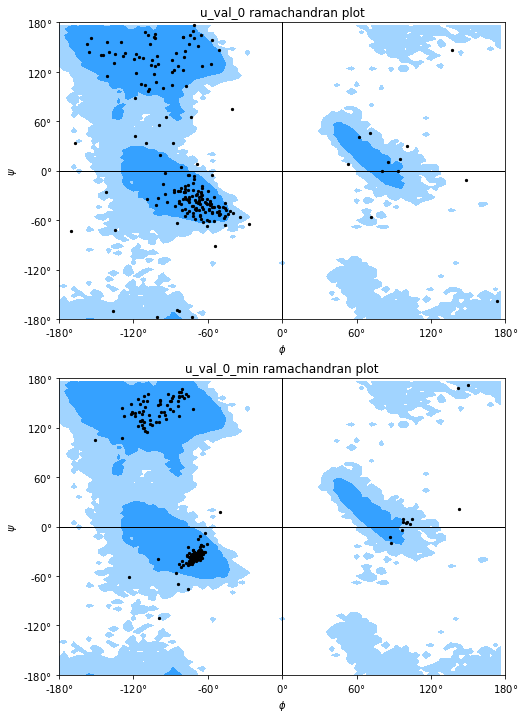

In [33]:
# Here we check that the phi=psi constraints really worked. After minimization 
# the ramachandran plot should show phi-psi angles clustered around the centroids
# To select a range of frames in a trajectory 
# use .run(startframe,endframe+1)

# Ramachandran angles in the reference protein. 
u_val_0 = mda.Universe('u_val_0.pdb','u_val_0.pdb')
u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')
u_val_0_rama = dihedrals.Ramachandran(u_val_0_protein).run()
plt.figure(figsize=(8, 12)) 
plt.subplot(2,1,1)
u_val_0_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0 ramachandran plot') 
u_val_0_phipsi_obs_radians = u_val_0_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_phipsi.shape}')
# print(u_val_0_phipsi_radians.shape)
# print(u_val_0_phipsi_radians[0][:6])

# Ramachandran angles in the minimized reference protein. 
u_val_0_min = mda.Universe('u_val_0_min.pdb','u_val_0_min.pdb')
u_val_0_min_protein = u_val_0_min.select_atoms('protein and not (name H* )')
u_val_0_min_rama = dihedrals.Ramachandran(u_val_0_min_protein).run()
plt.subplot(2,1,2)
u_val_0_min_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0_min ramachandran plot')          
u_val_0_min_phipsi_radians = u_val_0_min_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_min_phipsi.shape}')
# print(u_val_0_min_phipsi_radians.shape)
# print(u_val_0_min_phipsi_radians[0][:6])

#### Function to generate real space phi-psi structures from gan latent space vector

In [34]:
# Convert basin trajectory into angle trajectory using centroids
def single_frame_phipsi_radians_from_basins(basins,ref_centroids,ref_basins):

    deg_to_rad = np.pi/180.
    single_frame_phi_psi = []
    for j,basin in enumerate(basins):
        if basin>3 or basin<0:
            print(f'Warning: unexpected basin {basin} at position {j+1}')
            basin = np.rint(np.mean(ref_basins[:,j])).astype('int32')
            print(f'Replacing with basin {basin}')
            # print(*frame)
            # break

        phi_psi = ref_centroids[basin]*deg_to_rad
        single_frame_phi_psi.append(phi_psi.tolist())
        single_frame_phi_psi_ndarray = np.array(single_frame_phi_psi)

    return single_frame_phi_psi_ndarray


def GAN_sampler(model,num_basins=3,latent_dim=128,mean=0.0,stddev=1.0):
    random_latent_vector = tf.random.normal(shape=(num_basins,latent_dim),
                                            mean=mean,
                                            stddev=stddev)
    # random_latent_vector = tf.random.uniform(shape=(num_basins,latent_dim))    
    generated_basins = model.generator.predict(random_latent_vector)
    generated_basins *= 4
    generated_basins = np.rint(generated_basins).astype('int32')
    generated_basins -= 1
    generated_basins = np.squeeze(generated_basins,axis=-1)
    generated_basins = generated_basins[:,2:-2]    
    random_latent_vector = random_latent_vector.numpy() 
    
    return random_latent_vector, generated_basins 

                               
def gen_trj_from_latent_space(active_gan,
                              n_conf,
                              latent_dim,
                              digit_size,
                              ref_centroids,
                              ref_basins):

    gan_list = []
    random_latent_vectors = []
    # phi_psi_radians_list = []
    
    for i_conf in range(n_conf):

        random_latent_vector,generated_basins = GAN_sampler(active_gan,
                                      num_basins=1, 
                                      latent_dim=latent_dim)
        random_latent_vectors.append(random_latent_vector)
        
        print(*generated_basins[0])
        phipsi_radians = single_frame_phipsi_radians_from_basins(generated_basins[0],
                                                                 ref_centroids,
                                                                 ref_basins)
        # Modeller environment
        log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
        env = Environ()
        env.io.atom_files_directory = '.'
        env.edat.dynamic_sphere = True

        env.libs.topology.read(file='$(LIB)/top_heav.lib')
        env.libs.parameters.read(file='$(LIB)/par.lib')
        
        if i_conf == 0:
            # here we choose the minimized structure selected for extension
            code = 'u_val_0_min'                
        else:
            # here we choose the previous extended frame as the start frame 
            code = 'u_basin_GAN_min_' + str(i_conf-1)
            
        # code = 'u_val_0_min'                        
        ali_code = code + '.pdb'
        with open("alignment_min.ali", "w") as text_file:
            print(f'>P1;orig\nstructureX:{ali_code}:1:A:{n_res}:A::::\n{sequence}',file=text_file)
            print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)            

        mdl = complete_pdb(env, code + '.pdb')

        # Select all atoms:
        atmsel = Selection(mdl)       

        rsr = mdl.restraints   

        # Generate static restraints:
        rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

        # Example of phi and phi angles atoms definition
        # 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
        # 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

        # Add dynamic restraints on the phi-psi dihedrals
        for i in range(2,digit_size+2): 
            phi_1 = mdl.atoms['C:'+str(i-1)+':A']
            phi_2 = mdl.atoms['N:'+str(i)+':A']
            phi_3 = mdl.atoms['CA:'+str(i)+':A']
            phi_4 = mdl.atoms['C:'+str(i)+':A']    
            psi_1 = mdl.atoms['N:'+str(i)+':A']
            psi_2 = mdl.atoms['CA:'+str(i)+':A']
            psi_3 = mdl.atoms['C:'+str(i)+':A']
            psi_4 = mdl.atoms['N:'+str(i+1)+':A']

            # Binormal constraints
            rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                                   features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                             features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                                   weights=[100,100],
                                   means=[phipsi_radians[i-2,:].tolist(),
                                          phipsi_radians[i-2,:].tolist()],
                                   stdevs=[[0.1,0.1],[0.1,0.1]],
                                   correls=[0.5,0.5]))    

        mdl.restraints.write(file = code + '.rsr')

        # Addition of restraints to the default ones
        class RestrainModel(AutoModel):
            def special_restraints(self, aln):
                rsr = self.restraints
                # Add restraints from file:
                rsr.append(file = code + '.rsr')          

        a = RestrainModel(env,
                    alnfile  = 'alignment_min.ali',     # alignment filename
                    knowns   = 'orig',              # codes of the templates
                    sequence = 'seq',
                    )              # code of the target
        a.starting_model= 1                 # index of the first model
        a.ending_model  = 1                 # index of the last model
                                            # (determines how many models to calculate)
        a.make()                            # do comparative modeling

        a.write(file='u_basin_GAN_min_'+str(i_conf)+'.pdb')

        gan_list.append('u_basin_GAN_min_'+str(i_conf)+'.pdb')

    return gan_list,random_latent_vectors


### Latent space pdf representation

In [35]:
keras.backend.clear_session()
if 'discriminator' in globals():
    del discriminator
if 'generator' in globals():
    del generator
if 'active_gan' in globals():    
    del active_gan
       
# load discriminator and generator 
discriminator = keras.models.load_model("all_discriminator.tf")
generator = keras.models.load_model("all_generator.tf")

# Instantiate the WGAN model.
active_gan = WGAN(
    discriminator=discriminator,
    generator=generator,
    latent_dim=latent_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
active_gan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# generate real space conformations
n_conf = 200
centroids = all_centroids
digit_size = 212

all_gan_list,random_latent_vectors = gen_trj_from_latent_space(active_gan,
                                     n_conf,
                                     latent_dim,
                                     digit_size,
                                     all_centroids,
                                     all_basins)

0 0 0 0 0 3 0 1 2 1 1 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2345.78516

0 0 0 0 0 3 0 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2057.73657

0 0 0 0 0 3 0 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>>


>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1814.57251

0 0 0 0 0 3 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2018.86218

0 0 0 0 0 3 0 1 2 1 1 3 1 1 1 1 1 1 

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2014.38110

0 0 0 0 0 3 0 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>>


>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2245.82422

0 0 0 0 0 3 0 1 1 1 2 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
The following 1 residues contain 6-membered rings with poor geometries
after transfer from templates. Rebuilding rings from internal coordinates:
   <Residue 137:A (type PHE)>
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully p


>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1592.95776

0 0 0 0 0 3 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1421.54016

0 0 0 0 0 3 0 1 1 1 0 0 2 1 1 1 1 1 

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1638.14038

0 0 0 0 0 3 0 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>>


>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2401.33545

0 0 0 0 0 3 0 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
The following 1 residues contain 6-membered rings with poor geometries
after transfer from templates. Rebuilding rings from internal coordinates:
   <Residue 137:A (type PHE)>
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully p

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1736.34753

0 0 0 0 0 3 0 1 2 0 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>>


>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2407.33862

0 0 0 0 0 3 0 1 2 0 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
The following 1 residues contain 6-membered rings with poor geometries
after transfer from templates. Rebuilding rings from internal coordinates:
   <Residue 86:A (type PHE)>
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully pr


>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1852.45654

0 0 0 0 0 3 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1787.15588

0 0 0 0 0 3 0 1 1 1 0 3 2 1 1 1 1 1 

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2431.34497

0 0 0 0 0 3 0 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 2 0 0 0 3 1 1 1 1 1 1 1 1 1 1 1
The following 1 residues contain 6-membered rings with poor geometries
after transfer from templates. Rebuilding rings from internal coordinates:
   <Residue 86:A (type PHE)>
0 atoms in HETATM/BLK residues

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2321.79199

0 0 0 0 0 3 0 1 1 1 0 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>>


>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1789.97815

0 0 0 0 0 3 0 1 2 1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 2 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2397.97485

0 0 0 0 0 3 0 1 1 1 2 1 1 1 1 1 1 1 

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1774.99011

0 0 0 0 0 3 0 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>>


>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2027.52466

0 0 0 0 0 3 0 1 1 1 0 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 0 2 1 1 1 1 1 3 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             3453.98877

0 0 0 0 0 3 0 1 1 1 0 0 2 1 1 1 1 1 

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1931.12854

0 0 0 0 0 3 0 1 1 0 3 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>>


>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2786.75854

0 0 0 0 0 3 0 0 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 3 0 0 0 1 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2239.58228

0 0 0 0 0 3 0 1 2 1 1 2 1 1 1 1 1 1 

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             1888.90356

0 0 0 0 0 3 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>>

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2728.37915

0 0 0 0 0 3 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>>

In [41]:
# Check extended list
all_gan_list = all_gan_list[:n_conf]
# print(all_gan_list)

# If reverse is True the displayed trj will go back and forth
reverse = True

if reverse:
    all_gan_list.append(all_gan_list[::-1])

# ife tag as input_frame_early    
real_space_trj_ex1 = mda.Universe('u_val_0_min.pdb',all_gan_list)

# Fit in place extended trj to the reference structure
alignment_ex1 = align.AlignTraj(real_space_trj_ex1, u_val_0_min, in_memory=True)
alignment_ex1.run()

view_real_space_trj_ex1 = nv.show_mdanalysis(real_space_trj_ex1)

# clear the default representation
# view_real_space_trj_ex1.clear_representations()

# add more representation here
# view_real_space_trj_ex1.add_ball_and_stick()
# view_real_space_trj_ex1.add_cartoon()

# view_real_space_trj_ex1.parameters = dict(camera_type='perpective',
#                        background_color='black',
#                        fog_near=60,
#                        clip_dist=0)

view_real_space_trj_ex1.center()
view_real_space_trj_ex1


NGLWidget(max_frame=399)

### WGAN latent space representation

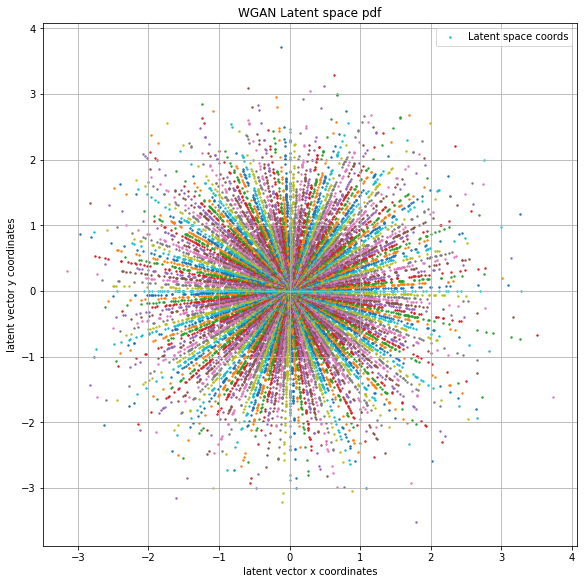

In [37]:
# large_random_latent_vector = []
angle = 0
n_vec = len(random_latent_vectors)

fig,ax1 = plt.subplots(1, 1, constrained_layout=True,figsize=(8,8))

for i in range(n_vec):
    #large_random_latent_vector += random_latent_vectors[i][0].tolist()
    
    angle_step = 2*np.pi/n_vec
    angle += angle_step
    angle_cos = np.cos(angle)
    angle_sin = np.sin(angle)
    rot_mat= np.array([[angle_cos,angle_sin],
                      [-angle_sin,angle_cos]])
    rot_vec_x = []
    rot_vec_y = []
    for j in range(latent_dim):
        point = np.array([0,random_latent_vectors[i][0][j]])
        rot_point = rot_mat@point
        rot_vec_x.append(rot_point[1])
        rot_vec_y.append(rot_point[0])

    # pdf = ax1.plot(rot_vec_x,rot_vec_y,'.')
    pdf = ax1.scatter(rot_vec_x,rot_vec_y,s=2.0)

    # arguments are passed to np.histogram    
    # pdf = plt.hist(large_random_latent_vector, bins='auto')  
    # plt.title("WGAN latent space histogram ")

ax1.grid()

# add figure labels and titles
ax1.set_ylabel('latent vector y coordinates')
ax1.set_xlabel('latent vector x coordinates')
ax1.legend([pdf],['Latent space coords'])
ax1.set_title('WGAN Latent space pdf')
plt.show()